# Some work on Toy Models of Superposition

The initial idea was that the post studied the existence of superposition, and the underlying geometry, but didn't seem to try to quantify it.

More specifically, my intuition came from the analogy the authors make with Johnson-Lindenstrauss lemma. I thought I might try to get a similar formula in the case of superposition, where the $\varepsilon$ used for distance error would there be linked to the sparsity, and the dimensions might be the ones of the feature space and the latent space.

Ideally I was hoping to get something like:

For all feature space of dimension $n$ (let's say $\subset \mathbb{R}^n$), and data distribution $D\subset \mathbb{R}^n$ of sparsity $\varepsilon$, for all $m > C F(\varepsilon)G(n)$, there exists $\phi:D\rightarrow L$, $\psi : L \rightarrow D$ with $L\subset \mathbb{R}^m$ such that:

$\forall x\in D, ||x-\psi(\phi(x))|| \leq H(\varepsilon)$

for some function $H$.

But this of course was an initial ideal hope...


## Setup

In [2]:
!pip install einops

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [2]:
@dataclass
class Config:
  n_features: int
  n_hidden: int

  # We optimize n_instances models in a single training loop
  # to let us sweep over sparsity or importance curves 
  # efficiently.

  # We could potentially use torch.vmap instead.
  n_instances: int
 
class Model(nn.Module):
  def __init__(self, 
               config, 
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,               
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)
    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch

class Model_lin(nn.Module):
  def __init__(self, 
               config, 
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,               
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)
    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch

Note that I save the dataset used for training, as well as the error per feature on the last batch used.

In [3]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[],
             dataset_bool=True):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)
  if dataset_bool:
    dataset = torch.empty((steps*n_batch, cfg.n_instances, cfg.n_features))
    dataset.to(model.W.device)
  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      if dataset_bool:
        dataset[step*n_batch:(step+1)*n_batch] = batch
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      loss.backward()
      opt.step()
    
      if hooks:
        hook_data = dict(model=model,
                         step=step, 
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )
  # compute the error by feature on the last batch
  with torch.no_grad():
    out = model(batch)
    error = (batch.abs() - out)**2
  if not dataset_bool:
    dataset = None
  return dataset, error

In [4]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

## Preliminaries

Since I wanted to play with high dimension models (more than 1000 features), plotting the same figures as in the post doesn't work (time issues), so I use other ways of visualizing.

In [25]:
config = Config(
    n_features = 100,
    n_hidden = 20,
    n_instances = 1,
)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (100 ** -torch.linspace(0, 1, config.n_features))[None, :],
    # Constant to 0.01 feature probability
    feature_probability = 0.01 * torch.ones((1, config.n_features), device=DEVICE),
)

In [26]:
dataset, loss = optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

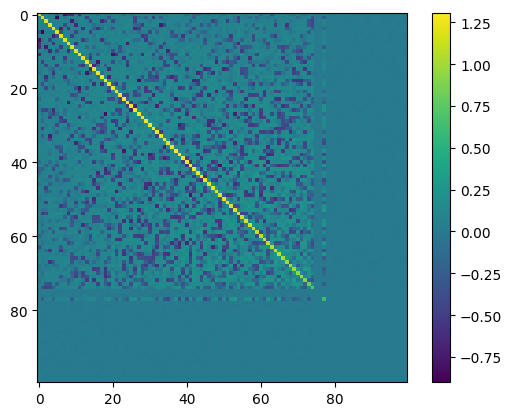

In [27]:
WtW = torch.einsum('sih,soh->sio', model.W, model.W).detach().cpu()
plt.imshow(WtW[0])
plt.colorbar()
plt.show()

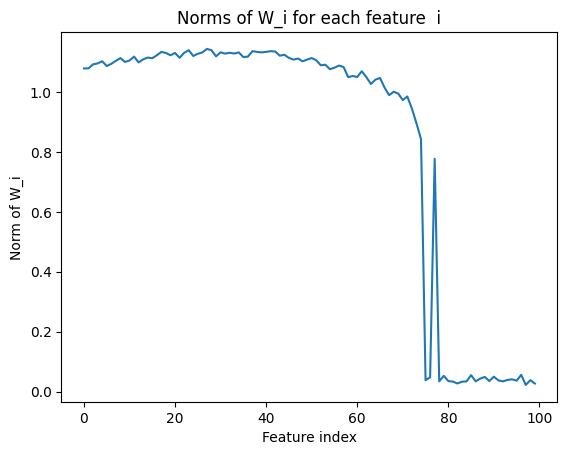

In [28]:
W0 = model.W.detach().cpu()[-1]
norms_list = torch.norm(W0, dim=1)
plt.plot(norms_list)
plt.xlabel('Feature index')
plt.ylabel('Norm of W_i')
plt.title('Norms of W_i for each feature  i')
plt.show()

The next plot is the plot of the mean error per feature on the training dataset. This is clearly not pertinent since the early datapoints in the training can't be considered as learned. And that is why we get such curves, where the accuracy is of the same order of magnitude for encoded features, and for not encoded features.

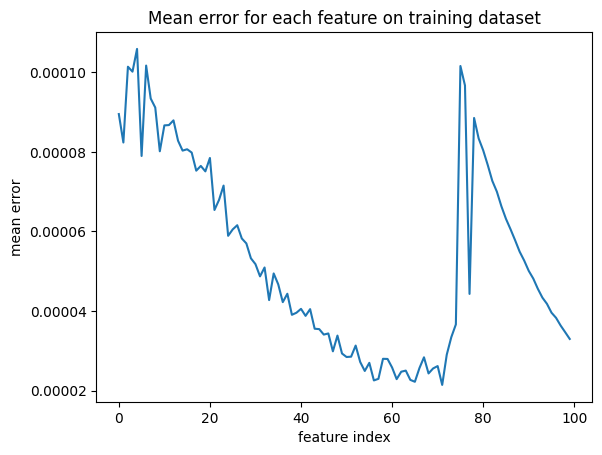

In [29]:
dataset = dataset.to(model.W.device)
with torch.no_grad():
    output = model(dataset)
    error = (model.importance*(dataset.abs() - output)**2)
mean_error = einops.reduce(error, 'b i f -> f', 'mean').cpu().numpy()
# plot
plt.plot(mean_error)
plt.xlabel('feature index')
plt.ylabel('mean error')
plt.title('Mean error for each feature on training dataset')
plt.show()

Just by curiosity, I plotted the error per feature on a random dataset (respecting sparsity), and verified what we get theoretically, i.e. that the error has the same behavior as the feature importance.

This confirms that when analizing the error on a dataset, this must be done on the latest datapoints of the training dataset only, as will be done in the following.

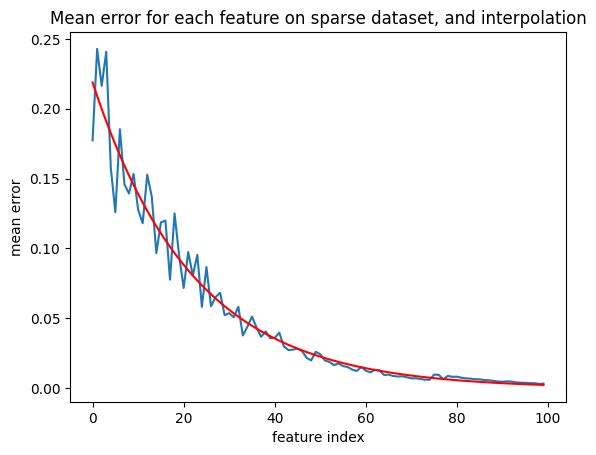

In [31]:
# create dataset with 1000 instances respecting sparsity
dataset_pers = torch.rand((1000, config.n_instances, config.n_features), device=DEVICE)
# set sparsity percents of features to 0
dataset_pers[dataset_pers < model.feature_probability] = 0
dataset_pers = dataset_pers.to(model.W.device)
with torch.no_grad():
    output = model(dataset_pers)
    error = (model.importance*(dataset_pers - output)**2)
mean_error = einops.reduce(error, 'b i f -> f', 'mean').cpu().numpy()
# plot
plt.plot(mean_error)
plt.xlabel('feature index')
plt.ylabel('mean error')
# interpolate with power law
import scipy
def power_law(x, a, b, c):
    return a / (100**(x/c)) + b
x = np.arange(0, 100)
y = mean_error
popt, pcov = scipy.optimize.curve_fit(power_law, x, y)
plt.plot(x, power_law(x, *popt), 'r-')
plt.title('Mean error for each feature on sparse dataset, and interpolation')
plt.show()

I also quickly tried to bias the loss in order to remove superposition, by penalizing the dot product between different features, but this proved to be too naive to work. I didn't have time to finetune or analyze it further, but I let the results below.

Basically it doesn't learn (pay attention to the scale of the plots). Maybe simply finetuning the hyperparameters of the loss my fix it.

In [45]:
def optimize_no_superposition(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  # I penalize superposition by adding scalar products of different lines to the loss
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)
  dataset = torch.empty((steps*n_batch, cfg.n_instances, cfg.n_features))
  dataset.to(model.W.device)
  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      dataset[step*n_batch:(step+1)*n_batch] = batch
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      WtW = torch.einsum('sih,soh->sio', model.W, model.W)
      loss += 0.001 * (WtW.abs().sum() - WtW.abs().diagonal(dim1=1, dim2=2).sum())
      loss.backward()
      opt.step()
    
      if hooks:
        hook_data = dict(model=model,
                         step=step, 
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )
  # compute the error by feature on the last batch
  with torch.no_grad():
    out = model(batch)
    error = (batch.abs() - out)**2
  return dataset, error

In [44]:
config = Config(
    n_features = 100,
    n_hidden = 20,
    n_instances = 1,
)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (100 ** -torch.linspace(0, 1, config.n_features))[None, :],
    # Constant to 0.01 feature probability
    feature_probability = 0.01 * torch.ones((1, config.n_features), device=DEVICE),
)

dataset, loss = optimize_no_superposition(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

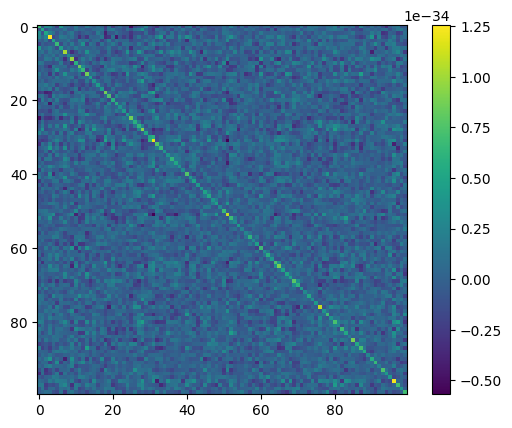

In [46]:
WtW = torch.einsum('sih,soh->sio', model.W, model.W).detach().cpu()
plt.imshow(WtW[0])
plt.colorbar()
plt.show()

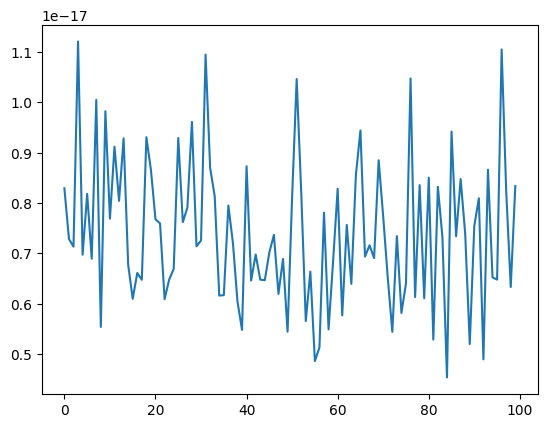

In [47]:
W0 = model.W.detach().cpu()[-1]
norms_list = torch.norm(W0, dim=1)
plt.plot(norms_list)
plt.show()

## Superposition in high-dimension

Now I just want to verify that superposition is not just a noise we observe in low-dimension.

In [5]:
import os

Observing the norms of each line of W in previous plots show that the summing the norm is not a correct estimator (actually it is when it comes to the behaviors we will study later) of the number of learned features.
Instead we count the number of features having a norm superior to $0.98$.

In [6]:
def render_features(model, which=np.s_[:]):
  cfg = model.config
  W = model.W.detach()
  W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

  interference = torch.einsum('ifh,igh->ifg', W_norm, W)
  interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

  polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
  net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()
  norms = torch.linalg.norm(W, 2, dim=-1).cpu()

  WtW = torch.einsum('sih,soh->sio', W, W).cpu()

  # width = weights[0].cpu()
  # x = torch.cumsum(width+0.1, 0) - width[0]
  x = torch.arange(cfg.n_features)
  width = 0.9

  which_instances = np.arange(cfg.n_instances)[which]
  my_sum = norms[0].sum()
  a = 1

  return norms, my_sum, W


def influence_of_layer_size(layer_size, features_nb, sparsity=0.05, other=None, force=False, dataset=True):
  if other is None:
    folder = "outputs"
  else:
    folder = other
  # check if the model has already been trained
  if (not force) and os.path.exists(f"./{folder}/model_{layer_size}_{features_nb}_{sparsity}.pt"):
    W = torch.load(f"./{folder}/W_{layer_size}_{features_nb}_{sparsity}.pt")
    sum = torch.load(f"./{folder}/sum_{layer_size}_{features_nb}_{sparsity}.pt")
    model = torch.load(f"./{folder}/model_{layer_size}_{features_nb}_{sparsity}.pt")
    loss = torch.load(f"./{folder}/loss_{layer_size}_{features_nb}_{sparsity}.pt")
    return sum, None, loss, W, model
  
  config = Config(
      n_features = features_nb,
      n_hidden = layer_size,
      n_instances = 1,
  )

  model = Model(
      config=config,
      device=DEVICE,
      # Exponential feature importance curve from 1 to 1/100
      importance = (100 ** -torch.linspace(0, 1, config.n_features))[None, :],
      # Polynomial feature importance curve from 1 to 1/100
    #   importance = (1/(torch.linspace(1, 10, config.n_features))**2)[None, :],
      # Constant importance set to 1
      # importance = torch.ones((1, config.n_features)),
      # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
      feature_probability = torch.tensor([[sparsity],]))


  dataset, loss = optimize(model, dataset=dataset)

  # save model
  torch.save(model.state_dict(), f"./{folder}/model_{layer_size}_{features_nb}_{sparsity}.pt")

  norms, sum, W = render_features(model, np.s_[::2])
  
  torch.save(W, f"./{folder}/W_{layer_size}_{features_nb}_{sparsity}.pt")
  torch.save(sum, f"./{folder}/sum_{layer_size}_{features_nb}_{sparsity}.pt")
  torch.save(loss, f"./{folder}/loss_{layer_size}_{features_nb}_{sparsity}.pt")
  return sum, dataset, loss, W, model


Learned features = 48 / 100 instead of 20 / 100


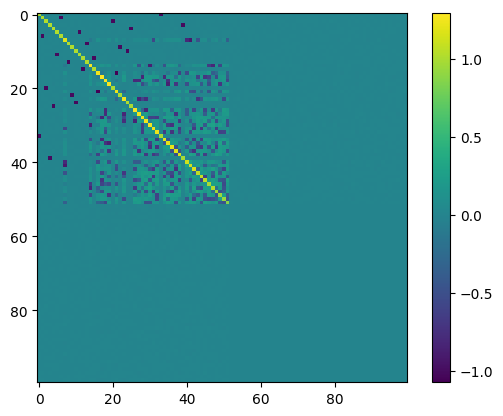

In [188]:
nb_features = 100
nb_layers = 20
sparsity = 0.05
_, _, _, W, _ = influence_of_layer_size(nb_layers, nb_features, sparsity=sparsity)
WtW = torch.einsum('sih,soh->sio', W, W).detach().cpu()
diag = torch.diag(WtW[0])
count = torch.sum(diag > 0.98).item()
print("Learned features = {} / {} instead of {} / {}".format(count, nb_features, nb_layers, nb_features))
plt.imshow(WtW[0])
plt.colorbar()
plt.show()

Learned features = 489 / 1000 instead of 200 / 1000


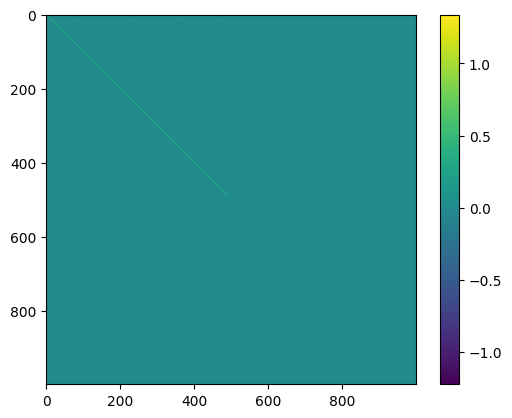

In [189]:
nb_features = 1000
nb_layers = 200
sparsity = 0.05
_, _, _, W, model = influence_of_layer_size(nb_layers, nb_features, sparsity=sparsity)
WtW = torch.einsum('sih,soh->sio', W, W).detach().cpu()
diag = torch.diag(WtW[0])
count = torch.sum(diag > 0.98).item()
print("Learned features = {} / {} instead of {} / {}".format(count, nb_features, nb_layers, nb_features))
plt.imshow(WtW[0])
plt.colorbar()
plt.show()

The strange thing here is that the norms are around 1 for more than twice the dimension of the hidden layer, which seems to mean there is superposition, while at the same time the scalar products seem to be null...

So either the color scale of the plot is not adapted, or the norm of the lines of $W$ are not a good estimator of the number of learned features.

We first verify the first hypothesis.

Learned features = 489 / 1000 instead of 200 / 1000


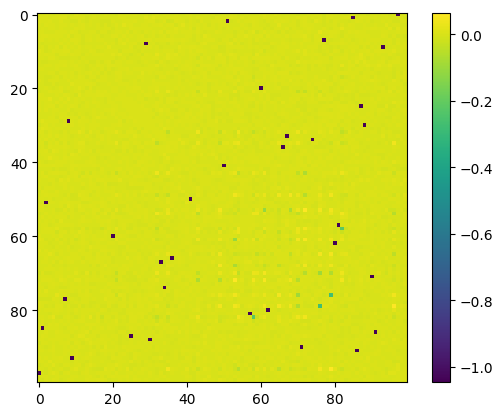

In [190]:
nb_features = 1000
nb_layers = 200
sparsity = 0.05
_, _, _, W, model = influence_of_layer_size(nb_layers, nb_features, sparsity=sparsity)
WtW = torch.einsum('sih,soh->sio', W, W).detach().cpu()
diag = torch.diag(WtW[0])
count = torch.sum(diag > 0.98).item()
print("Learned features = {} / {} instead of {} / {}".format(count, nb_features, nb_layers, nb_features))
plt.imshow((WtW[0]- torch.diag(torch.diag(WtW[0])))[:100, :100])
plt.colorbar()
plt.show()

Here I plotted $W^tW$ on the first $100$ features, and removed the diagonal. So in fact the first hypothesis seems to be the right one : it was only a visualization issue.

However I am still a bit not convinced by the link I wanted to make between learned features and encoded ones.

Learned features = 489 / 1000 instead of 200 / 1000


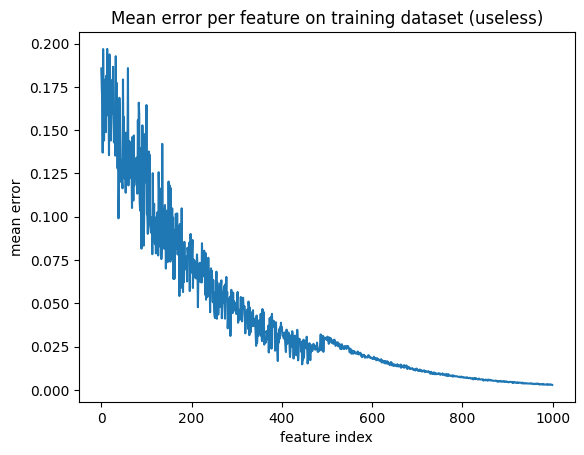

In [48]:
nb_features = 1000
nb_layers = 200
sparsity = 0.05
_, _, _, W, model_v = influence_of_layer_size(nb_layers, nb_features, sparsity=sparsity)
config = Config(
    n_features = nb_features,
    n_hidden = nb_layers,
    n_instances = 1,
)
model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (100 ** -torch.linspace(0, 1, config.n_features))[None, :],

    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = torch.tensor([[sparsity],]))
model.load_state_dict(torch.load(f"./outputs/model_{nb_layers}_{nb_features}_{sparsity}.pt"))

WtW = torch.einsum('sih,soh->sio', W, W).detach().cpu()
diag = torch.diag(WtW[0])
count = torch.sum(diag > 0.98).item()
print("Learned features = {} / {} instead of {} / {}".format(count, nb_features, nb_layers, nb_features))

# create dataset with 1000 instances respecting sparsity
dataset_pers = torch.rand((1000, 1, nb_features), device=DEVICE)
dataset_pers[:int(sparsity*1000), :, :] = 0
dataset_pers = dataset_pers.to(DEVICE)
with torch.no_grad():
    output = model(dataset_pers)
    error = (model.importance*(dataset_pers - output)**2)
mean_error = einops.reduce(error, 'b i f -> f', 'mean').cpu().numpy()
# plot
plt.plot(mean_error)
plt.xlabel('feature index')
plt.ylabel('mean error')
plt.title('Mean error per feature on training dataset (useless)')
plt.show()

[ALREADY SAID BEFORE]

I was quite confused on why I got such curves, i.e. why the error for supposedly non encoded features was lower than for encoded (and thus supposedly learned) features.

I thought it might be due to the fact that I was testing on a distribution the network had not really learned.

So below I test instead on the last batch the model was trained on.

Learned features = 489 / 1000 instead of 200 / 1000


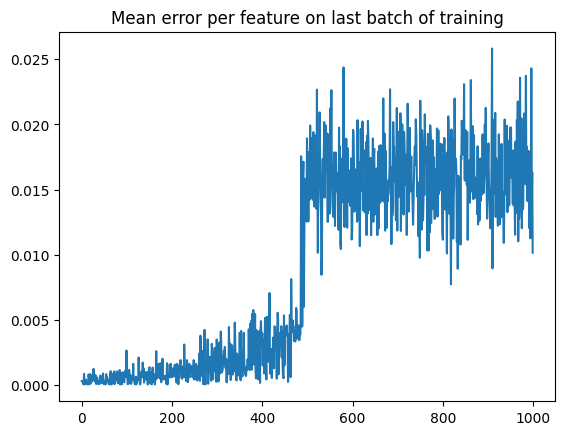

In [49]:
nb_features = 1000
nb_layers = 200
sparsity = 0.05
_, _, loss, W, model_v = influence_of_layer_size(nb_layers, nb_features, sparsity=sparsity, dataset=False)
config = Config(
    n_features = nb_features,
    n_hidden = nb_layers,
    n_instances = 1,
)
model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (100 ** -torch.linspace(0, 1, config.n_features))[None, :],

    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = torch.tensor([[sparsity],]))
model.load_state_dict(torch.load(f"./outputs/model_{nb_layers}_{nb_features}_{sparsity}.pt"))

WtW = torch.einsum('sih,soh->sio', W, W).detach().cpu()
diag = torch.diag(WtW[0])
count = torch.sum(diag > 0.98).item()
print("Learned features = {} / {} instead of {} / {}".format(count, nb_features, nb_layers, nb_features))
loss = einops.reduce(loss, 'b i f -> f', 'mean').cpu().numpy()
plt.plot(loss)
plt.title('Mean error per feature on last batch of training')
plt.show()

Here we get something far more logical, and it confirms that the norms counting was a good estimator, so I'll keep it in the following.

## Quantifying superposition

Note that I am aware that if learning went wrong for some parameters, I am keeping them forever since I do the computing only once, but I ran (I think) for sufficient parameters to make potential outliers neglictable.

Also note that I didn't use the several instances run functionality of the base code, but I should have.

And last note: the name of the function influence_of_layer_size is not really pertinent, since I also use it for sparsity influence.

### Computing G(n) (number of learnable features wrt feature space dimension)

Doing something rigorous would be computationally very costly, since I would have for each feature space dimension, to find the smallest model that learns it perfectly.

Instead I simulate the variation of feature space dimension by just varying the size of the hidden layer. It is important to note that having a strictly decreasing feature importance is fundamental in this case.

Note that this may have side effects that I didn't see.

I ran the experiment for a feature space of size 10000 and sparsity 0.05 for a very very long time, but it was at the beginning of my work, and I sadly hadn't thought to save the tensors at that time. Hopefully I had printed the norms sum, so here they are !

In [5]:
string = "[tensor(969.2097), tensor(1670.8032), tensor(2286.5815), tensor(2810.8335), tensor(3265.4170), tensor(3665.6843), tensor(4018.9507), tensor(4365.7300), tensor(4693.4146), tensor(4993.7246), tensor(5269.0298), tensor(5518.7520), tensor(5746.1621), tensor(5953.2363), tensor(6149.0718), tensor(6330.8994), tensor(6501.2637), tensor(6665.3955), tensor(6820.6660), tensor(6961.2739), tensor(7098.1328), tensor(7222.0654), tensor(7351.8540), tensor(7481.9316), tensor(7599.3838), tensor(7705.0840), tensor(7806.0327), tensor(7903.5913), tensor(7989.9121), tensor(8079.1191), tensor(8159.8735), tensor(8236.2490), tensor(8312.4453), tensor(8381.7930), tensor(8456.5654), tensor(8520.0879), tensor(8584.3018), tensor(8653.6602), tensor(8713.1484), tensor(8775.3340), tensor(8837.3691), tensor(8897.9170), tensor(8953.9805), tensor(9017.2617), tensor(9070.2178), tensor(9132.8926), tensor(9192.2646), tensor(9249.9590), tensor(9308.0469), tensor(9360.1602), tensor(9425.2773), tensor(9483.9688), tensor(9538.4092), tensor(9595.8545), tensor(9657.8760), tensor(9711.7031), tensor(9765.5615), tensor(9820.9219), tensor(9888.2461), tensor(9947.1582), tensor(9998.5264), tensor(10058.1143), tensor(10117.7705), tensor(10170.7129), tensor(10221.9316), tensor(10277.6953), tensor(10332.0664), tensor(10378.0127), tensor(10431.7754), tensor(10470.9893), tensor(10504.1465), tensor(10533.7217), tensor(10558.1240), tensor(10574.2920), tensor(10592.2754), tensor(10607.5693), tensor(10616.5020), tensor(10620.9180), tensor(10627.9766), tensor(10636.3916), tensor(10634.4033), tensor(10627.4277), tensor(10627.1992), tensor(10631.8340), tensor(10623.3291), tensor(10618.8486), tensor(10604.1104), tensor(10598.5850), tensor(10604.5527), tensor(10587.4551), tensor(10581.2295), tensor(10580.9180), tensor(10567.3184), tensor(10550.8477), tensor(10553.4863), tensor(10548.1367), tensor(10530.8389), tensor(10519.8887), tensor(10515.5469)]"

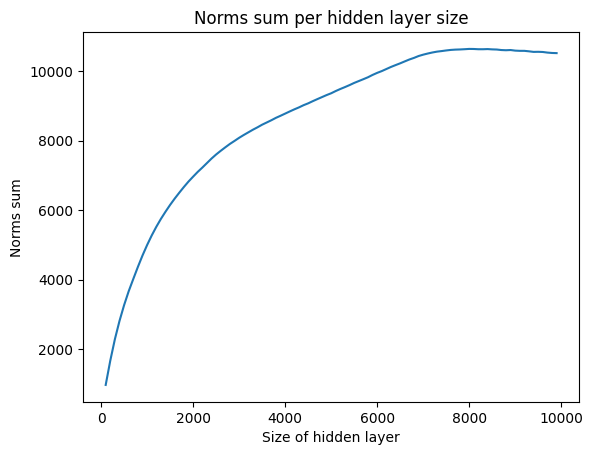

In [6]:
if isinstance(string, str):
    string = string[1:-1]
    string = string.split(", ")
    string = [float(i[7:-1]) for i in string]
x = np.arange(100, 10000, 100)
plt.plot(x, string)
plt.xlabel('Size of hidden layer')
plt.ylabel('Norms sum')
plt.title('Norms sum per hidden layer size')
plt.show()

The general behavior is quite intuitive. We have an increase until around 8000, which obviously is the superposition capacity associated with a feature space of size 1000, and then there is no more increase, since the network can't do better.

In an ideal work, the increase would follow a logarithmic law (as in Johnson-Lindenstrauss), so I try to interpolate, and compare with a simple polynomial interpolation.

(Note that I remove the values after 7000, to be sure to not take into account the constant phase.)

In [7]:
import numpy as np
layer_size_range = np.arange(100, 10000, 100)
print(len(layer_size_range))
# make a copy sums of string
sums = string.copy()

99


/tmp/ipykernel_562/4221086529.py:11: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + c) + b # the 1e-3 is to avoid log(0)


[  2968.42295922 -15943.89629772    177.98283251]
[ 5.97729081e+03  1.45809851e-01 -1.12600033e+04]


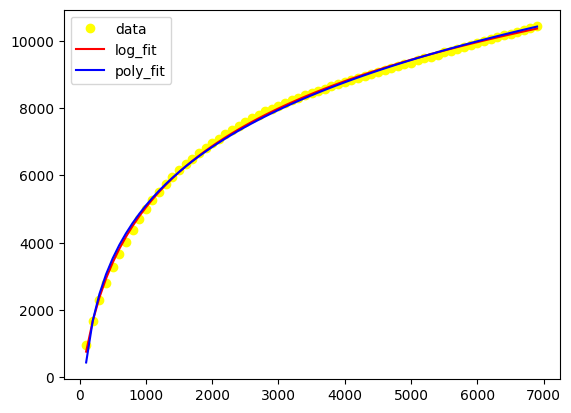

In [8]:
# keep only for values of layer_size before 600
indices = np.where(layer_size_range < 7000)
layer_size_keep = layer_size_range[indices]
sums_keep = np.array(sums)[indices]
# reorder by values of layer_size
indices = np.argsort(layer_size_keep)
layer_size_keep = layer_size_keep[indices]
sums_keep = sums_keep[indices]
# try to approximate by a logarithmic function
def f(x, a, b, c):
    return a * np.log(x + c) + b # the 1e-3 is to avoid log(0)
# fit
from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
# plot
plt.plot(layer_size_keep, sums_keep, 'o', color='yellow', label='data')
plt.plot(layer_size_keep, f(layer_size_keep, *popt), 'r-', label='log_fit')
plt.legend()
# compare by approximating with a power law function of the form y = a * x^b + c
def g(x, a, b, c):
    return a * x**b + c
popt, pcov = curve_fit(g, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
plt.plot(layer_size_keep, g(layer_size_keep, *popt), 'b-', label='poly_fit')
plt.legend()
plt.show()

Unfortunately, the increase does not seem to follow either a logarithmic law or a polynomial one, or at least not more one than the other.

A closer look at the complete curve leads me to think that there are actually not one but two phase changes: the basic one around $x_2=7500$, and another one around $x_1 = 4000$.
Before $x_1$ the curve seems to be logarithmic or other, but after it actually seems to be linear.

So let's verify that.

/tmp/ipykernel_562/3266689212.py:10: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + c) + b # the 1e-3 is to avoid log(0)


[  3402.58475117 -19382.86958826    288.07699744]
[ 1.08916109e+03  2.97414620e-01 -3.53401220e+03]


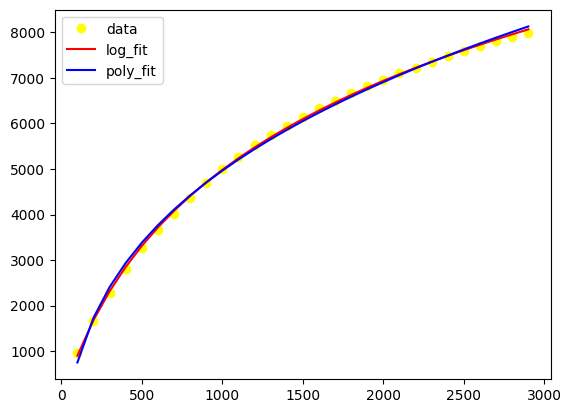

In [9]:
indices = np.where(layer_size_range < 3000)
layer_size_keep = layer_size_range[indices]
sums_keep = np.array(sums)[indices]
# reorder by values of layer_size
indices = np.argsort(layer_size_keep)
layer_size_keep = layer_size_keep[indices]
sums_keep = sums_keep[indices]
# try to approximate by a logarithmic function
def f(x, a, b, c):
    return a * np.log(x + c) + b # the 1e-3 is to avoid log(0)
# fit
from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
# plot
plt.plot(layer_size_keep, sums_keep, 'o', color='yellow', label='data')
plt.plot(layer_size_keep, f(layer_size_keep, *popt), 'r-', label='log_fit')
plt.legend()
# compare by approximating with a power law function of the form y = a * x^b + c
def g(x, a, b, c):
    return a * x**b + c
popt, pcov = curve_fit(g, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
plt.plot(layer_size_keep, g(layer_size_keep, *popt), 'b-', label='poly_fit')
plt.legend()
plt.show()

/tmp/ipykernel_562/2826989565.py:10: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + c) + b # the 1e-3 is to avoid log(0)


[  17322.97288927 -169055.59141932   24726.39471134]
Error with log_fit:  23.215744262449498
[3.21018334e+00 8.22510370e-01 5.82784071e+03]
Error with poly_fit:  23.91074013334785
[5.73370160e-01 6.49617624e+03]
Error with linear_fit:  39.67046545643865


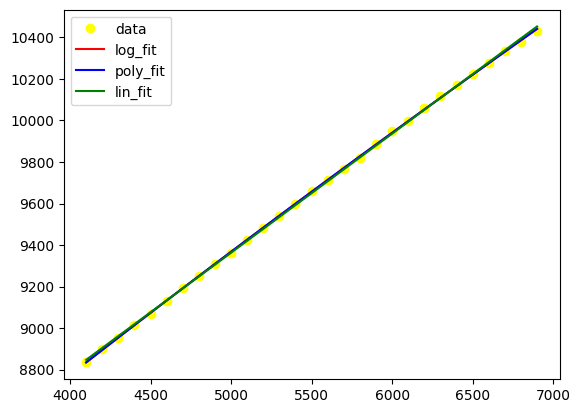

In [10]:
indices = np.where((layer_size_range > 4000) & (layer_size_range < 7000))
layer_size_keep = layer_size_range[indices]
sums_keep = np.array(sums)[indices]
# reorder by values of layer_size
indices = np.argsort(layer_size_keep)
layer_size_keep = layer_size_keep[indices]
sums_keep = sums_keep[indices]
# try to approximate by a logarithmic function
def f(x, a, b, c):
    return a * np.log(x + c) + b # the 1e-3 is to avoid log(0)
# fit
from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
# plot
plt.plot(layer_size_keep, sums_keep, 'o', color='yellow', label='data')
plt.plot(layer_size_keep, f(layer_size_keep, *popt), 'r-', label='log_fit')
error = np.linalg.norm(sums_keep - f(layer_size_keep, *popt))
print("Error with log_fit: ", error)
plt.legend()
# compare by approximating with a power law function of the form y = a * x^b + c
def g(x, a, b, c):
    return a * x**b + c
popt, pcov = curve_fit(g, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
plt.plot(layer_size_keep, g(layer_size_keep, *popt), 'b-', label='poly_fit')
error = np.linalg.norm(sums_keep - g(layer_size_keep, *popt))
print("Error with poly_fit: ", error)
plt.legend()
def h(x, a, b):
    return a * x + b
popt, pcov = curve_fit(h, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
plt.plot(layer_size_keep, h(layer_size_keep, *popt), 'g-', label='lin_fit')
error = np.linalg.norm(sums_keep - h(layer_size_keep, *popt))
print("Error with linear_fit: ", error)
plt.legend()
plt.show()

Unfortunately, none of the interpolations done seem convincing.
By lack of time I couldn't investigate further.

However a phase change between low and high dimensions does not seem stupid, and analizing the geometry of superposition as done in the rest of the post when varying this dimension may give an answer to this behavior.

(I unfortunately didn't read the whole post so I cannot really make conjectures...)

--------

I just realized I actually reran it for spasity 0.03, but it seems that there was an issue at the end.

In [ ]:
layer_size_range = range(100, 10000, 100)
features_nb = 10000
sparsity = 0.03
sums = []
for layer_size in layer_size_range:
    print(layer_size)
    sums.append(influence_of_layer_size(layer_size, features_nb, sparsity))

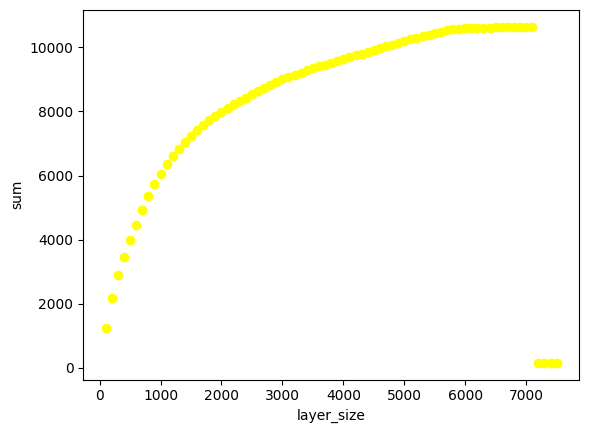

In [ ]:
import os
sums = []
errors = []
layer_size_range = []
for file in os.listdir("./outputs"):
    file_split = file.split("_")
    if file_split[0] == "W" and file_split[3] == "0.03.pt" and file_split[2] == "10000":
        layer_size_range.append(int(file_split[1]))
        features_nb = int(file_split[2])
        sparsity = float(file_split[3][:-3])
        W = torch.load(f"./outputs/{file}")
        norms = torch.linalg.norm(W, 2, dim=-1).cpu()
        sums.append(torch.sum(norms))
layer_size_range = np.array(layer_size_range)
# print(sums)
# print(layer_size_range)
plt.plot(layer_size_range, sums, 'o', color='yellow')
plt.xlabel("layer_size")
plt.ylabel("sum")
plt.show()

I didn't have the time to do interpolation on it.

---------------------------

I also reran the experiments for lower dimension (1000) to see if it was a coincidence.

In [ ]:
layer_size_range = range(10, 1000, 10)
features_nb = 1000
sparsity = 0.05
sums5 = []
for layer_size in layer_size_range:
    sums5.append(influence_of_layer_size(layer_size, features_nb, sparsity))

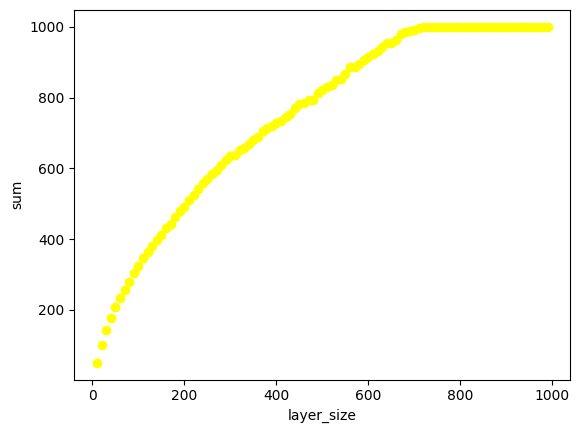

In [12]:
# for all files W of outputs where sparsity is 0.05 and features_nb is 1000 and for any layer_size
# compute the norm of each line and compute the number of line that has a value > 0.95
# add this number to a list
# plot the list
import os
sums = []
layer_size_range = []
for file in os.listdir("./outputs"):
    file_split = file.split("_")
    if file_split[0] == "W" and file_split[3] == "0.05.pt" and file_split[2] == "1000":
        layer_size_range.append(int(file_split[1]))
        W = torch.load(f"./outputs/{file}")
        norms = torch.linalg.norm(W, 2, dim=-1).cpu()
        sums.append(torch.sum(norms > 0.95))
layer_size_range = np.array(layer_size_range)
# print(sums)
# print(layer_size_range)
plt.plot(layer_size_range, sums, 'o', color='yellow')
plt.xlabel("layer_size")
plt.ylabel("sum")
plt.show()

/tmp/ipykernel_562/332895652.py:11: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + c + 1e-10) + b # the 1e-3 is to avoid log(0)


[  514.06352007 -2499.08414889   139.58541604]
Error with log_fit:  55.45387151712778
[ 45.24311659   0.48443453 -94.1716232 ]
Error with poly_fit:  39.45827977159169


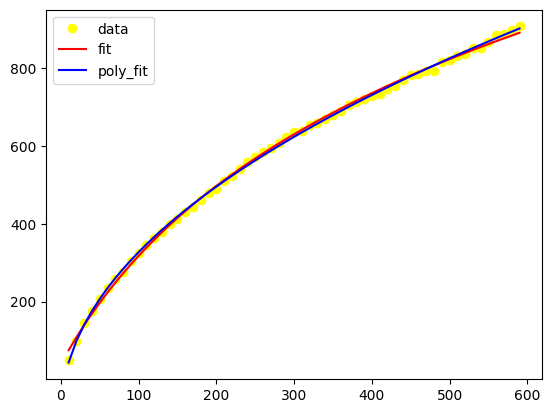

In [13]:
# keep only for values of layer_size before 600
indices = np.where(layer_size_range < 600)
layer_size_keep = layer_size_range[indices]
sums_keep = np.array(sums)[indices]
# reorder by values of layer_size
indices = np.argsort(layer_size_keep)
layer_size_keep = layer_size_keep[indices]
sums_keep = sums_keep[indices]
# try to approximate by a logarithmic function
def f(x, a, b, c):
    return a * np.log(x + c + 1e-10) + b # the 1e-3 is to avoid log(0)
# fit
from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
# plot
plt.plot(layer_size_keep, sums_keep, 'o', color='yellow', label='data')
plt.plot(layer_size_keep, f(layer_size_keep, *popt), 'r-', label='fit')
plt.legend()
error = np.linalg.norm(sums_keep - f(layer_size_keep, *popt))
print("Error with log_fit: ", error)
# compare by approximating with a power law function of the form y = a * x^b + c
def g(x, a, b, c):
    return a * x**b + c
popt, pcov = curve_fit(g, layer_size_keep, sums_keep, maxfev=10000)
print(popt)
plt.plot(layer_size_keep, g(layer_size_keep, *popt), 'b-', label='poly_fit')
plt.legend()
error = np.linalg.norm(sums_keep - g(layer_size_keep, *popt))
print("Error with poly_fit: ", error)
plt.show()

Again nothing very convincing.

Actually if I refer to the "the simplest the better" law, a square root seems to approximate the curve quite well, so it could be that.

But still I am not sure of anything.

### Computing $F(\varepsilon)$ (influence of the sparsity on superposition)

In [ ]:
sparsity_range = np.linspace(0.05, 0.4, 10)
print(sparsity_range)
features_nb = 1000
layer_size = 400
sums = []
for sparsity in sparsity_range:
    sums.append(influence_of_layer_size(layer_size, features_nb, sparsity))

In [14]:
# for all file in outputs that correspond to a layer_size of 400 and a features_nb of 1000
# add the sum to a list
# plot the list
sums = []
sparsity_range = []
for file in os.listdir("./outputs"):
    if file.startswith("sum_400_1000_"):
        sparsity_range.append(float(file.split("_")[3][:-3]))
        sums.append(torch.load(f"./outputs/{file}"))
sparsity_range = np.array(sparsity_range)

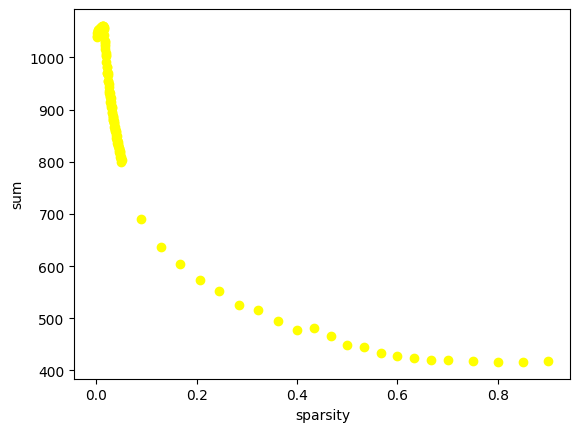

In [15]:
import matplotlib.pyplot as plt
# plot the elements with o
plt.plot(sparsity_range, sums, 'o', color='yellow')
plt.xlabel("sparsity")
plt.ylabel("sum")
plt.show()

Linear: coef = [-753.68496655  901.33740398], error = 751.6005305960396
Log: coef = [-1.38365621e+02  3.62234481e+02 -9.44091250e-03], error = 84.45047046240579
Monome: coef = [ 3.86476717e+02  2.40248585e-03 -2.47781689e-01], error = 45.49463568796285
Monome simple: coef = [ 4.77383970e+02 -2.09846878e-01 -9.30425288e+01], error = 48.12144245900196


/tmp/ipykernel_562/1220864899.py:21: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + c + 1e-10) + b
/tmp/ipykernel_562/1220864899.py:30: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**c
/tmp/ipykernel_562/1220864899.py:39: RuntimeWarning: overflow encountered in power
  return a * (x)**c + b


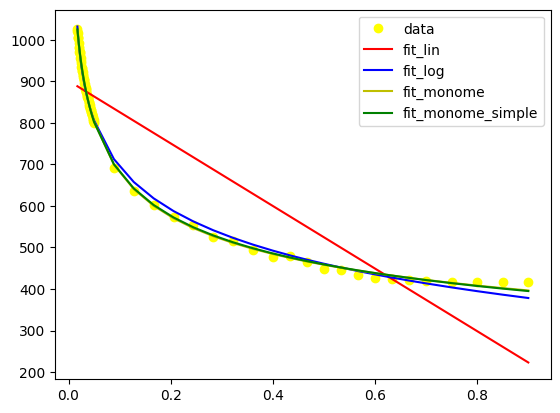

In [25]:
# keep only for values of sparsity after 0.017
indices = np.where(sparsity_range > 0.017)
sparsity_keep = sparsity_range[indices]
sums_keep = np.array(sums)[indices]
# reorder by values of sparsity
indices = np.argsort(sparsity_keep)
sparsity_keep = sparsity_keep[indices]
sums_keep = sums_keep[indices]
# try to approximate by linear function a * sparsity + b with scipy
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a * x + b
# fit
popt, pcov = curve_fit(lin, sparsity_keep, sums_keep)
print("Linear: coef = {}, error = {}".format(popt, np.linalg.norm(lin(sparsity_keep, *popt) - sums_keep)))
# plot
plt.plot(sparsity_keep, sums_keep, 'o', color='yellow', label='data')
plt.plot(sparsity_keep, lin(sparsity_keep, *popt), 'r-', label='fit_lin')
# same for logarithmic function
def log(x, a, b, c):
    return a * np.log(x + c + 1e-10) + b
# fit
popt, pcov = curve_fit(log, sparsity_keep, sums_keep, maxfev=10000)
print("Log: coef = {}, error = {}".format(popt, np.linalg.norm(log(sparsity_keep, *popt) - sums_keep)))
# plot
plt.plot(sparsity_keep, log(sparsity_keep, *popt), 'b-', label='fit_log')
plt.legend()
# same for monomes a(x+b)**c
def monome(x, a, b, c):
    return a * (x + b)**c
# fit
popt, pcov = curve_fit(monome, sparsity_keep, sums_keep, maxfev=10000)
print("Monome: coef = {}, error = {}".format(popt, np.linalg.norm(monome(sparsity_keep, *popt) - sums_keep)))
# plot
plt.plot(sparsity_keep, monome(sparsity_keep, *popt), 'y-', label='fit_monome')
plt.legend()
# same for monomes a(x)**c
def monome(x, a, c, b):
    return a * (x)**c + b
# fit
popt, pcov = curve_fit(monome, sparsity_keep, sums_keep, maxfev=10000)
print("Monome simple: coef = {}, error = {}".format(popt, np.linalg.norm(monome(sparsity_keep, *popt) - sums_keep)))
# plot
plt.plot(sparsity_keep, monome(sparsity_keep, *popt), 'g-', label='fit_monome_simple')
plt.legend()
plt.show()

It is quite hard again to be sure of any interpolation.

The behavior seems rather polynomial, but an analyzis of the coefficients does not give anything intuitive.

-----------

I still show some analysis on particular regions of sparsity.

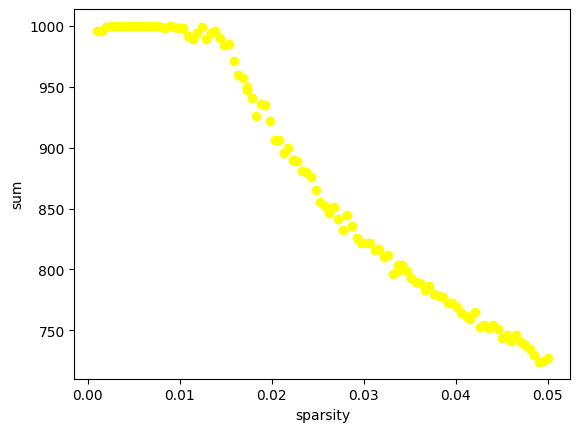

In [ ]:
import matplotlib.pyplot as plt
# plot the elements with o
plt.plot(sparsity_range, sums, 'o', color='yellow')
plt.xlabel("sparsity")
plt.ylabel("sum")
plt.show()

What is intersting here is the stagnation for very low sparsity. I would naively think that this is due to the fact that for low sparsity, the non null values are mainly considered as noise, so that the network just learns the null function. But it might be something else...

[-6542.93088486  1111.07685374]
[ 9.50750633e+02 -1.35028848e-01 -6.22229346e+02]


/tmp/ipykernel_562/1976835277.py:22: RuntimeWarning: overflow encountered in power
  return a * x**b + c


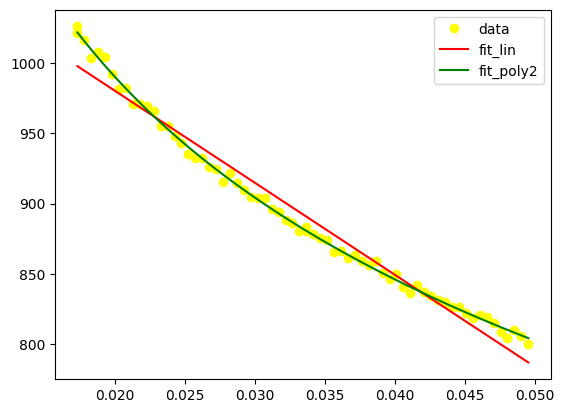

In [29]:
# keep only for values of sparsity after 0.017 and before 0.050
indices = np.where((sparsity_range > 0.017) & (sparsity_range < 0.050))
sparsity_keep = sparsity_range[indices]
sums_keep = np.array(sums)[indices]
# reorder by values of sparsity
indices = np.argsort(sparsity_keep)
sparsity_keep = sparsity_keep[indices]
sums_keep = sums_keep[indices]
# try to approximate by linear function a * sparsity + b with scipy
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a * x + b
# fit
popt, pcov = curve_fit(lin, sparsity_keep, sums_keep)
print(popt)
# plot
plt.plot(sparsity_keep, sums_keep, 'o', color='yellow', label='data')
plt.plot(sparsity_keep, lin(sparsity_keep, *popt), 'r-', label='fit_lin')
# same with polynomial of degree 2 
def poly2(x, a, b, c):
    # return a * x**2 + b * x + c
    return a * x**b + c
# fit
popt, pcov = curve_fit(poly2, sparsity_keep, sums_keep)
print(popt)
# plot
plt.plot(sparsity_keep, poly2(sparsity_keep, *popt), 'g-', label='fit_poly2')
plt.legend()

I thought there might be a phase change (not the one constant/decreasing) at 0.050 and looked at the first phase. It seems nicely interpolated by an inverse function...

### Something strange and probably false

I finish with something a bit strange.

Here is the influence of sparsity curve I found when plotting the mean error on random dataset for nb_features = 1000, and nb_hidden = 100.

In [ ]:
sparsity_range = np.linspace(0.1, 0.7, 30)
print(sparsity_range)
features_nb = 1000
layer_size = 100
sums100 = []
for sparsity in sparsity_range:
    sums100.append(influence_of_layer_size(layer_size, features_nb, sparsity, other="linear"))

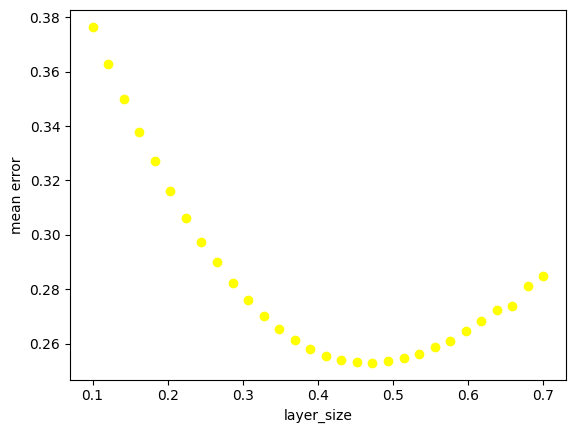

In [32]:
import os
sums = []
errors = []
sparsity_range = []
for file in os.listdir("./linear"):
    file_split = file.split("_")
    if file.startswith("W_100_1000_"):
        sparsity_range.append(float(file_split[3][:-3]))
        sparsity = float(file_split[3][:-3])
        features_nb = int(file_split[2])
        W = torch.load(f"./linear/{file}")
        norms = torch.linalg.norm(W, 2, dim=-1).cpu()
        sums.append(torch.sum(norms))
        # load the model from corresponding file
        config = Config(
            n_features = features_nb,
            n_hidden = int(file_split[1]),
            n_instances = 1,
        )
        model = Model(
            config=config,
            device=DEVICE,
            importance = torch.ones((1, config.n_features)),
            # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
            feature_probability = torch.tensor([[sparsity],]))
        model.load_state_dict(torch.load(f"./linear/model_{file_split[1]}_{file_split[2]}_{file_split[3]}"))
        model.eval()
        dataset = torch.rand(5000, features_nb)
        dataset = torch.where(torch.rand_like(dataset) < sparsity, torch.zeros_like(dataset), dataset).to(DEVICE)
        with torch.no_grad():
            output = model(dataset)
        # compute the mean error for each feature
        mse = torch.mean(((output - dataset)**2)**(1/2), dim=0)
        # compute the sum of the mse
        sum_mse = torch.mean(mse).item()
        errors.append(sum_mse)
sparsity_range = np.array(sparsity_range)
# print(sums)
# print(layer_size_range)
plt.plot(sparsity_range, errors, 'o', color='yellow')
plt.xlabel("layer_size")
plt.ylabel("sum")
plt.show()

And it perfectly fits a polynomial of degree $2$.

This is actually the same thing we get with no relu (and that can be verified theoretically !).

So one could think this is due, as said, to the wrong choice of dataset. However I plotted the norms sum associated.

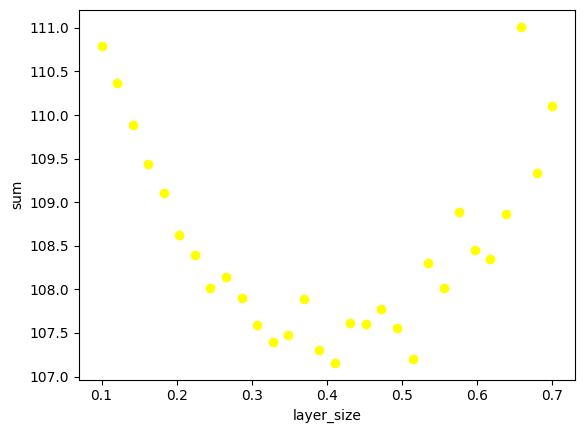

In [33]:
plt.plot(sparsity_range, sums, 'o', color='yellow')
plt.xlabel("layer_size")
plt.ylabel("sum")
plt.show()

And it seems pretty much the same !

I honestly think there is 50% chance that I did a mistake in the implementation at some point when I ran this experiment so I should rerun it, but in case this is true, it seems to say that in high dimension, for very low size of hidden layer, the network behaves as a linear one.

But again I am quite sure this is false (and I rather think we should get very different curves for the random dataset, and for the norms sum).